In [107]:
import collections
import torch
import torch.utils.data as Data
import torch.nn as nn
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch.nn.functional as F
import seaborn as sns

### 数据处理

In [40]:
with open('fra.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# 左边为英文句子,右边为对应的法文句子
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [41]:
def preprocess_nmt(text):
    """预处理"英语<--->法语"数据集"""

    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格(non-breaking space)
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 使用小写字母替换大写字母
    text = text.lower()
    # 在单词和标点符号之间插⼊空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)


text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [42]:
def tokenize_nmt(text,
                 num_examples=None):  # 使用的训练样本数
    """词元化"英语<--->法语"数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        source.append(parts[0].split(' '))  # 英文数据
        target.append(parts[1].split(' '))  # 法文数据
    return source, target


source, target = tokenize_nmt(text)
source[:10], target[:10]  # 每个子列表表示一个句子的切分(根据' '切分)

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!'],
  ['fire', '!'],
  ['help', '!'],
  ['jump', '.'],
  ['stop', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!'],
  ['au', 'feu', '!'],
  ['à', "l'aide", '!'],
  ['saute', '.'],
  ['ça', 'suffit', '!']])

In [43]:
def count_corpus(tokens):
    """Count token frequencies"""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    """Vocabulary for text"""

    def __init__(self, tokens=None, min_freq=2, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        # Sort according to frequencies
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        """Index for the unknown token"""
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


# '<unk>':未知词元
# '<pad>':填充词元
# '<bos>':开始词元
# '<eos>':结束词元
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [44]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 句子截断
    return line + [padding_token] * (num_steps - len(line))  # 句子填充


truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [45]:
def build_array_nmt(lines, vocab, num_steps):
    """将文本序列转换为数值矩阵"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]  # 使用'<eos>'表示句子的结尾
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).to(dtype=torch.int32).sum(1)
    return array, valid_len


array, valid_len = build_array_nmt(source, src_vocab, 15)
print(array)  # 通过vocab将句子从token转换为idx(等长,不足部分1填充)
print(array.shape)
print(valid_len)  # 每个句子的实际长度

tensor([[  47,    4,    3,  ...,    1,    1,    1],
        [2944,    4,    3,  ...,    1,    1,    1],
        [ 435,  126,    3,  ...,    1,    1,    1],
        ...,
        [ 381,   60,   26,  ...,  480,   68, 4696],
        [  66,  295,   90,  ...,   10, 1170, 1526],
        [  17,  176,   32,  ...,    8, 1963,   16]])
torch.Size([167130, 15])
tensor([ 3,  3,  3,  ..., 15, 15, 15])


In [46]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator"""
    dataset = Data.TensorDataset(*data_arrays)
    return Data.DataLoader(dataset, batch_size, shuffle=is_train)


def load_data_nmt(text, batch_size, num_steps, num_examples=None):
    """返回翻译数据集的迭代器和词汇表"""
    source, target = tokenize_nmt(text, num_examples=num_examples)
    src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab


train_iter, src_vocab, tgt_vocab = load_data_nmt(text, batch_size=32, num_steps=15, num_examples=500)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 34,  19,  12,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [  7, 141,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 81,  10,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 56,  37,   5,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 46, 108,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [  6, 135,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 46,  82,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 52,  70,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 13, 124, 125,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [  6,  38,   9,   4,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1],
        [ 99,   5,   3,   1,   1,   1,   1,   1,   1,   1

### Seq2Seq模型

In [47]:
class Seq2SeqEncoder(nn.Module):
    """用于序列到序列学习的循环神经⽹络编码器"""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0, bidirectional=False):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers,
                          dropout=dropout, bidirectional=bidirectional)

    def forward(self, X):
        # X.shape=(N, T, C);其中T为序列的长度,N为min-batch的大小,C为输入的特征数目
        X = self.embedding(X)
        # 循环神经默认输入要求为:(T, N, C)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        # output.shape=(T, N, hidden_size)
        # state.shape=(num_layers, N, hidden_size)
        return output, state


encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, hidden_size=16,
                         num_layers=2)
encoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


In [48]:
# state[-1].shape=(N, hidden_size)
state[-1].shape

torch.Size([4, 16])

In [49]:
def masked_softmax(X, valid_lens=None):
    """通过在最后⼀个轴上遮蔽元素来执⾏softmax操作"""

    def sequence_mask(X, valid_len, value=0):
        """Mask irrelevant entries in sequences"""
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 被遮蔽的元素使⽤⼀个⾮常⼤的负值替换,使其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)


class AdditiveAttention(nn.Module):
    """加性注意⼒"""

    def __init__(self, key_size, query_size, num_hiddens, dropout):
        super(AdditiveAttention, self).__init__()
        # self.W_k.weight.shape = (num_hiddens, key_size)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # self.W_q.weight.shape = (num_hiddens, query_size)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # self.W_v.weight.shape = (1, num_hiddens)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # queries:(b, q?, query_size) x (query_size, num_hiddens) = (b, ?q, num_hiddens)
        # keys:(b, k?, key_size) x (key_size, num_hiddens) = (b, ?k, num_hiddens)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries.unsqueeze(2).shape=(b, ?q, 1, num_hiddens)
        # keys.unsqueeze(1).shape=(b, 1, ?k, num_hiddens)
        # features.shape=(b, ?q, ?k, num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # scores:(b, ?q, ?k, num_hiddens) x (num_hiddens, 1) = (b, ?q, ?k, 1)
        # scores.squeeze(-1).shape=(b, ?q, ?k)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values.shape=(b, ?k, ?v)
        # 返回值:(b, ?q, ?k) x (b, ?k, ?v) = (b, ?q, ?v)
        return torch.bmm(self.dropout(self.attention_weights), values)


class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqAttentionDecoder, self).__init__()
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        # output.shape=(T, N, hidden_size)
        # hidden_state.shape=(num_layers, N, hidden_size)
        outputs, hidden_state = enc_outputs
        # output.permute(1, 0, 2).shape=(N, T, hidden_size)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs.shape=(N, T, hidden_size)
        # hidden_state.shape=(num_layers, N, hidden_size)
        enc_outputs, hidden_state, enc_valid_lens = state  # 元组解包
        # self.embedding(X).shape=(N, T, C)
        # X.permute(1, 0, 2).shape=(T, N, C)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # x.shape=(N, 1)
            # query.shape.shape=(N, 1, hidden_size)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context.shape=(N, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)

            # 在特征维度上连结
            # torch.unsqueeze(x, dim=1).shape=(N, 1, C)
            # x.shape=(N, 1, C+hidden_size)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # x.permute(1, 0, 2).shape=(1, N, C+hidden_size)
            # out.shape=(1, N, hidden_size)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)  # hidden_size被更新
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # torch.cat(outputs, dim=0).shape=(T, N, hidden_size)
        # 全连接层之后:outputs.shape=(T, N, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        # outputs.permute(1, 0, 2).shape=(N, T, vocab_size)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [50]:
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # X.shaep=(N, T)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [51]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture"""

    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs, enc_valid_lens=None)
        return self.decoder(dec_X, dec_state)

### 自定义损失函数

In [52]:
def sequence_mask(X, valid_len, value=0):
    """每行有效长度之外的值进行填充"""
    maxlen = X.size(1)
    # 广播机制
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


X = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
# 通过零值化屏蔽不相关的项,以便后⾯任何不相关预测的计算都是与零的乘积,结果都等于零
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [53]:
class MaskedSoftmaxCELoss(nn.Module):
    """带遮蔽的softmax交叉熵损失函数"""

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        unweighted_loss = nn.CrossEntropyLoss(reduction='none')(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss


loss = MaskedSoftmaxCELoss()
# 指定这些序列的有效⻓度为4、2、0,可以看出第⼀个序列的损失为第二个序列的两倍,第三个序列的损失为零
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

### 模型训练

In [54]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练seq2seq模型"""
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(data_iter):
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher Forcing
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3)  # 梯度裁剪
            optimizer.step()
            if batch_idx % 300 == 0:
                print('loss:', l.sum().item())

In [55]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 32, 25
lr, num_epochs, device = 0.005, 200, torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iter, src_vocab, tgt_vocab = load_data_nmt(text, batch_size, num_steps, num_examples=1000)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                                  dropout)

net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

loss: 30.767738342285156
loss: 17.232234954833984
loss: 17.264766693115234
loss: 16.037120819091797
loss: 13.0699462890625
loss: 12.554055213928223
loss: 10.070682525634766
loss: 11.019838333129883
loss: 9.724077224731445
loss: 8.603453636169434
loss: 9.36562728881836
loss: 7.3100690841674805
loss: 8.503435134887695
loss: 5.955378532409668
loss: 7.333395957946777
loss: 7.572638034820557
loss: 6.08033561706543
loss: 6.818236351013184
loss: 6.442068099975586
loss: 5.490764617919922
loss: 6.134253978729248
loss: 5.138355731964111
loss: 6.274439334869385
loss: 4.479513168334961
loss: 5.545270919799805
loss: 5.029084205627441
loss: 4.876688003540039
loss: 4.8801727294921875
loss: 4.997369766235352
loss: 4.919951438903809
loss: 5.0525102615356445
loss: 4.136142253875732
loss: 4.401761054992676
loss: 4.312302112579346
loss: 3.573528289794922
loss: 4.24594259262085
loss: 3.6256749629974365
loss: 3.6741600036621094
loss: 3.5520405769348145
loss: 4.4646525382995605
loss: 3.4607677459716797
loss:

### 模型预测与评估

In [56]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device):
    """Seq2Seq模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    # 最终的隐藏状态
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_lens=None)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 使用具有预测最高可能性的词元,作为解码器在下⼀时间步的输⼊
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:  # 如果单词为'<eos>',则表示输出序列预测结束
            break
        output_seq.append(pred)
    # 重新翻译回句子
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [75]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
all_attension_weight_seq = []
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    all_attension_weight_seq.append(dec_attention_weight_seq)
    chencherry = SmoothingFunction()
    # 使用bleu指标进行结果评估
    blen = sentence_bleu([translation], fra, weights=(1 / 2.0, 1 / 2.0), smoothing_function=chencherry.method1)
    print(f'{eng} => {translation}, bleu {blen:.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> ., bleu 0.588
i'm home . => je suis malade ., bleu 0.594


In [129]:
first_sentence_attention_weight = torch.stack([i[0][0][0] for i in all_attension_weight_seq[0]], 1)[:3, :]
first_sentence_attention_weight = first_sentence_attention_weight.cpu().detach()
first_sentence_attention_weight

tensor([[0.5928, 0.1411, 0.1578],
        [0.1478, 0.1733, 0.1606],
        [0.1615, 0.2203, 0.1465]])

<AxesSubplot:>

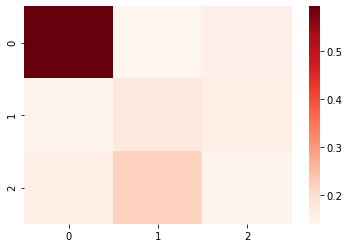

In [130]:
sns.heatmap(first_sentence_attention_weight, cmap='Reds')